<a href="https://colab.research.google.com/github/JamieBali/hopfieldSudokuSolver/blob/main/Hebbian_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hebbian Learning

Following "The Effects of Hebbian Learning on Optimisation in Hopfield Networks" (Watson, Buckley, and Mills), I intend to implement Hebbian Learning, and attempt to scale up the solution to solve Sudoku problems.

In [29]:
## imports
import random
import numpy as np
import math
import pandas

## Models

The state of a Hopfield Network consisting of N discrete states $S_i$ where $i = 1,2,...,N$ can be written as $S = (s_i,...,s_N)$

$S_i(t+1) = Θ[∑_j ω_iⱼ S_i(t)]$
<br> Where ω are the elements of the connection matrix Ω, and Θ is the Heaviside threshold function.

The Hopfield network is run by repeatedly choosing a unit, $i$, uniformly at random and setting its state according to the above formula. 

Energy = -∑ᵢⱼωᵢⱼsᵢsⱼ


In [56]:
##
# The energy of a problem needs to be reduced. This function finds what the energy is at a given state.
##
def getEnergy(weights, neurones):
  #Energy = -sum(w_ij x s_i x s_j)
  sum = 0
  for i in range(0,len(neurones)):
    for j in range(0,len(neurones)):
      sum += (weights[i][j] * neurones[i] * neurones[j])
  energy = sum * -1
  return energy

##
# The heaviside function is an activation function that returns +1 for values >= 0, and -1 for values less than 0
##
def heaviside(value):
  if value < 0:
    return -1
  else:
    return 1

##
# The step function takes an index (i) for a given neurone to look at. This will be picked randomly.
##
def step(neurones, weights, i):
  # S_i (t+1) = Θ[sum(ω_ij * S_i (t)]

  #sum = 0
  #for j in range(0,len(neurones)):
  #  sum += neurones[j] * weights[i][j]

  neuroneCopy = np.copy(neurones)
  #neuroneCopy[i] = heaviside(sum)
  neuroneCopy[i] = neuroneCopy[i] * -1
  
  if getBoltzmanProbability(neurones, neuroneCopy) == 1:
    return neuroneCopy
  else:
    return neurones

## Boltzman Machine

The boltzman machine is a schocastic counterpart of the Hopfield network where a single state change is accepted probabilistically according to the change in energy it produces.

We can describe such a dynamical process more generally via a probability of accepting a stochatsic change to the system state:

$P[S(t+1) <- f(S(t))] = Θ'(ΔE)$ 

In [59]:
def getBoltzmanProbability(nt, ntplus, size = 9): # refering to weights at t+1, neurones at t+1, weights at t, and neurones at t respectively
  # t+1 - t = ΔE
  t1 = sudokuEnergy(ntplus, size)
  t = sudokuEnergy(nt, size)
  Delta = t1 - t  

  # below is a threshold function that takes values of 0 and 1 for negative and non-negative arguments respectively.
  return int(Delta <= 0)


# Random Restart

A random restart model is an option for avoiding the trap of a local optima, so the model can be programmed to periodically take a random state configuration, $R=\{-1|1\}ᴺ$, every τ steps.

In [5]:
def randomRestart(length):
  return random.choices([-1,1], k=length)

# Hebbian Learning

By combining the functions written previously with a Hebbian Learning mechanism, we can update the weights of the network as we tend towards a solution. We want to update the weights with this system before we perform the random restart function, but only at the end of relaxation.

In [6]:
def updateWeights(weights, neurones, delta): # where this delta value is a learning rate.
  # ω_ij(τ+1) = ω_ij(τ) + (δ/τ)(s_i(t) * s_j(t))
  updatedWeights = []
  for i in range(0, len(neurones)):
    temp = []
    for j in range(0, len(neurones)):
      if i == j:
        temp.append(1)
      else:
        temp.append(heaviside(weights[i][j] + (delta * neurones[i] * neurones[j])))
    updatedWeights.append(temp)
  return updatedWeights

"In principle, the original behaviour of the system need not be governed by a weight matrix, but by some arbitrary energy function, $e(S)$, which is just some function of the state." (Watson, Buckley, and Mills)

In [62]:
def getLocation(row, column, number, size):
  return int((column * (size ** 2)) + (row * size) + number)
  

##
# This arbitrary energy function seeks to minimize the weight of a Sudoku problem. If the problem is perfectly solved, the energy should be 0.
# The energy will then be affected by the learned weights matrix.
##
def sudokuEnergy(neurones, size = 9):
  # For a completed 
  energy = 4*(size**2)

  # sum across i for all j,k (each number appears in each row once and only once)
  for column in range(0,size):
    for number in range(0,size):
      count = 0
      for row in range(0,size):
        if neurones[getLocation(row, column, number, size)] == 1:
          count += 1
      if count == 1:
        energy -= 1
      if count > 1:
        energy += 50 # a rule violation should lead to a massive increase in energy so it isn't picked

  # sum across j for all i,k (each number appears in each column once and only once)
  for row in range(0,size):
    for number in range(0,size):
      count = 0
      for column in range(0,size):
        if neurones[getLocation(row, column, number, size)] == 1:
          count += 1
      if count == 1:
        energy -= 1
      if count > 1:
        energy += 50

  # sum across k for all i,j (each tile contains only one number)
  for row in range(0,size):
    for cloumn in range(0,size):
      count = 0
      for number in range(0,size):
        if neurones[getLocation(row, column, number, size)] == 1:
          count += 1
      if count == 1:
        energy -= 1
      if count > 1:
        energy += 50

  # sum across i,j,k for each sub-grid on the board (each number appears in each sub-grid once and only once)
  temp = int(math.sqrt(size))
  for rowitt in range(0,temp):               # these row and cloumn itterators allows each individual sub-grid to be searched, and allows for easy grid size change
    for columnitt in range(0,temp):
      for row in range(0,temp):
        for column in range(0,temp):
          sum = 0
          for number in range(0, size):
            if neurones[getLocation((rowitt * temp) + row, (columnitt * temp) + column, number, size)] == 1:
              sum += 1
          if sum == 1:
            energy -= 1
          if sum > 1:
            energy += 50

  return energy
  

# Network Creation

In [8]:
# this puzzle was taken from the paper i am following. (V. Mladenov et al.)
paper = [[0,0,0,9,5,7,0,0,0],[7,6,0,0,0,0,0,1,0],[8,0,5,0,0,6,0,2,0],[3,0,9,0,4,0,0,0,0],[0,0,8,0,0,0,1,0,0],[0,0,0,0,2,0,5,0,6],[0,8,0,1,0,0,6,0,4],[0,3,0,0,0,0,0,7,1],[0,0,0,4,3,2,0,0,0]]

# these three were taken randomly from sudoku.com
easy = [[0,0,0,0,7,9,0,3,0],[5,0,2,0,6,1,4,7,8],[3,7,6,0,8,5,9,0,2],[0,1,7,5,0,0,8,0,0],[2,0,9,8,3,0,0,0,0],[0,0,0,0,2,0,0,4,0],[0,0,0,0,5,0,2,0,1],[0,2,3,0,0,0,0,5,4],[1,0,0,7,0,0,0,0,0]]
medium = [[0,3,1,0,5,0,0,2,0],[0,0,0,0,0,2,9,0,5],[2,0,0,0,1,0,0,0,0],[3,5,0,0,9,0,0,7,0],[7,0,0,5,0,0,0,4,0],[0,1,0,7,0,3,2,0,0],[1,2,6,3,0,0,0,0,0],[0,9,0,8,0,5,0,0,0],[5,0,0,0,2,0,7,0,0]]
hard = [[0,4,0,0,0,5,0,6,0],[0,0,5,4,2,0,0,0,0],[0,0,1,6,0,3,5,0,4],[0,0,0,0,0,0,7,0,0],[0,3,7,0,0,0,0,1,0],[9,0,0,0,0,4,3,5,0],[0,0,4,2,5,0,0,0,0],[0,0,0,0,0,0,0,7,6],[6,0,9,0,7,0,0,0,5]]

# this puzzle is taken from "expert star sudoku," a book of level 6 sudoku.
expert = [[0,0,0,0,1,0,0,0,0],[0,9,0,0,0,5,0,0,0],[5,0,0,0,7,6,0,0,0],[0,0,4,0,0,0,2,7,0],[0,2,0,0,0,0,5,0,9],[0,7,0,8,0,0,0,0,0],[0,0,1,0,0,3,0,0,0],[6,0,0,1,2,0,0,8,0],[7,8,0,0,0,0,9,0,0]]


solved = [[2,1,6,3,7,8,4,5,9],[8,5,4,2,9,1,6,3,7],[9,7,3,4,5,6,8,1,2],[7,8,1,5,6,2,3,9,4],[5,3,2,9,4,7,1,8,6],[4,6,9,1,8,3,2,7,5],[6,2,8,7,3,5,9,4,1],[1,4,5,8,2,9,7,6,3],[3,9,7,6,1,4,5,2,8]]


In [17]:
def networkFormat(puzzle, size):
  neurones = []
  for row in range(0,size):
    for column in range(0, size):
      temp = [-1,-1,-1,-1,-1,-1,-1,-1,-1]
      num = puzzle[row][column]
      if num > 0:
        temp[num-1] = 1
      for x in temp:
        neurones.append(x)
  return neurones

def readableFormat(neurones, size):
  puzzle = []
  temp = []
  for x in range(0,size**2):
    tile = neurones[x*size:((x+1)*size)]
    found = False
    for y in range(0,size):
      if tile[y] == 1:
        temp.append(y + 1)
        found = True
        break
    if found == False:
      temp.append(0)
    if (x + 1) % 9 == 0:
      puzzle.append(temp)
      temp = []
  return puzzle

# Theta Values

We can use theta as a value to represent given values at the start of the puzzle. We don't want these theta values to be changed, as they act as the constraints of the puzzle. We have 2 options for theta values - we can either update the neurones to factor in the theta values after any changes, or at the end of a relaxation period, or we can put in a prevention measure to stop the theta values from being changed in the first place. We will implement the latter solution.

In [46]:
def getThetaValues(neurones):
  theta = []
  for num, value in enumerate(neurones):
    if value == 1:
      theta.append(num)
  return theta

# Testing

In [10]:
def createWeights(neurones, size = 9):
  weights = []
  for x in range(0,len(neurones)):
    temp = np.zeros(len(neurones))

    # rule 1, each tile may only contain one number
    # this is performed dynamically across each level of the weights matrix
    holder = math.floor(x/size)           # to find which tile of the grid we're on
    for y in range(0,size):               # for each neurone representing a possible number on that tile
      temp[(holder*size) + y] = -1        # we inhibit response from the respective neurone
    
    # rule 2, each row may only contain each number once
    # this, too, is performed dynamically so we can vary the size of the grid later
    holder = math.floor(x/(size**2))            # to find which row we're on
    holder = (holder * (size**2)) + (x % size)  # modulus of x by size tells us which number we're looking for.
    for y in range(0,size):                   # for each tile in that row
      temp[holder+(size*y)] = -1                # inhibit the response from the respective neurones

    # rule 3, each column may only contain each number once
    # the process for this rule is easier
    holder = x % (size**2)          # find the value on row 0 for the respective number
    for y in range(0,size):       # for each row
      temp[holder+((size**2)*y)] = -1    # inhibit the respective number in that column

    #rule 4, each sub-grid may only contain each number once
    # this is the most complex one
    s = math.sqrt(size)
    c = math.floor(x/(s**3))%s         # this gives the neuron a column index from 0 to size-1
    r = size * (math.floor(x/(s**5)))  # this gives the neuron a row index from 0 to 2(size)
    ind = (s**3)*(c+r)                 # this gives is the index of the neuron in the top-left corner of that sub-grid
    holder = int(ind + (x%size))            # lastly we get the holder of the top-left index with the depth of the number
    for y in range(0,int(s)):
      temp[holder + (y*size)] = -1
      for z in range(1,int(s)):
        temp[holder + (y*size) + (z*(size**2))] = -1

    for y in range(0, len(temp)):
      if temp[y] == 0:
        temp[y] = 1

    temp[x] = 1
    weights.append(temp)

  return weights

In [53]:
def runNetwork(puzzle, size, relaxation, epochs, verbose = False):
  neurones = networkFormat(puzzle, size)
  weights = createWeights(neurones, size)
  theta = getThetaValues(neurones)

  for epoch in range(0, epochs):
    for x in range(0,relaxation):
      i = random.randint(0,len(neurones)-1)
      if i in theta:          # this prevents any changes happening to the theta values in the network, ensuring the initial values are not modulated
        continue
      neurones = step(neurones, weights, i)
      if verbose and x % 50 == 0:
        print(readableFormat(neurones, 9))
        print(sudokuEnergy(neurones, 9))  
  return neurones

In [63]:
print(easy)
n = runNetwork(easy, 9, 1000, 1, False)
print(readableFormat(n, 9))

[[0, 0, 0, 0, 7, 9, 0, 3, 0], [5, 0, 2, 0, 6, 1, 4, 7, 8], [3, 7, 6, 0, 8, 5, 9, 0, 2], [0, 1, 7, 5, 0, 0, 8, 0, 0], [2, 0, 9, 8, 3, 0, 0, 0, 0], [0, 0, 0, 0, 2, 0, 0, 4, 0], [0, 0, 0, 0, 5, 0, 2, 0, 1], [0, 2, 3, 0, 0, 0, 0, 5, 4], [1, 0, 0, 7, 0, 0, 0, 0, 0]]
[[4, 6, 8, 1, 7, 9, 5, 3, 0], [5, 0, 2, 9, 6, 1, 4, 7, 8], [3, 7, 6, 0, 8, 5, 9, 1, 2], [0, 1, 7, 5, 4, 3, 8, 2, 6], [2, 0, 9, 8, 3, 4, 0, 6, 5], [9, 0, 5, 3, 2, 0, 1, 4, 7], [8, 3, 0, 4, 5, 7, 2, 0, 1], [0, 2, 3, 6, 1, 8, 7, 5, 4], [1, 8, 4, 7, 0, 6, 3, 9, 0]]


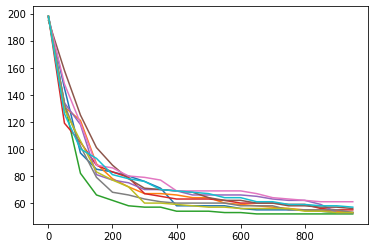

In [45]:
_pandasIndex = []
for x in range(0,1000):
    if x % 50 == 0:
      _pandasIndex.append(x)

df = pandas.DataFrame(_pandasData, _pandasIndex)
df.plot(legend = None)

In [61]:

solution = [[0, 0, 8, 1, 7, 9, 5, 3, 6], [5, 9, 2, 3, 6, 1, 4, 7, 8], [3, 7, 6, 4, 8, 5, 9, 1, 2], [6, 1, 7, 5, 4, 0, 8, 9, 3], [2, 5, 9, 8, 3, 4, 0, 6, 7], [7, 8, 0, 9, 2, 6, 1, 4, 5], [4, 3, 0, 6, 5, 7, 2, 8, 1], [9, 2, 3, 0, 1, 8, 7, 5, 4], [1, 4, 5, 7, 9, 2, 6, 3, 9]]
sudokuEnergy(networkFormat(solution, 9), 9)

35